<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/24_4_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Используя предложенный датасет произведений классической музыки, обучи модель "сочинять" музыку на произведениях только одного Шопена.
В качестве начальной последовательности для генерации используйте произведения Моцарта.
Для получения трех баллов достаточно получить ноты и аудиофайл с вашим сгенерированным произведением.
Хотите 4 балла? Добавьте в функцию генерации параметр temperature - температура модели. Температура модели влияет на генерацию. Более низкие температуры соответствуют более точному предсказанию, а более высокие температуры приводят к более случайной генерации.
Хотите 5 баллов? Используйте для обучения модели три переменные для представления ноты: pitch, step и duration. Высота звука (pitch) - это качество восприятия звука в виде номера ноты в формате MIDI. Шаг (step) - это время, прошедшее с предыдущей ноты или начала трека. Длительность (duration) - это продолжительность воспроизведения ноты в секундах и разница между временем окончания и началом ноты.

In [1]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
from music21 import *

# настраиваем окружение в соответствии с документацией
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

In [3]:
# Импортируем библиотеки
import tensorflow
import os
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
from music21 import *
import fluidsynth

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.optimizers import Adamax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [4]:
!wget https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "classical-music-midi" -d ./dataset
!dir ./dataset

--2024-10-23 16:40:16--  https://storage.yandexcloud.net/academy.ai/classical-music-midi.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2751606 (2.6M) [application/x-zip-compressed]
Saving to: ‘classical-music-midi.zip’

classical-music-mid 100%[===================>]   2.62M  1.81MB/s    in 1.4s    

2024-10-23 16:40:18 (1.81 MB/s) - ‘classical-music-midi.zip’ saved [2751606/2751606]

Albeniz    Borodin	Christmas  Granados  Mendelssohn  Rachmaninoff	Sinding
Bach	   Brahms	Clementi   Grieg     Moszkowski   Ravel		Tchaikovsky
Balakirev  Burgmueller	Debussy    Haydn     Mozart	  Schubert
Beethoven  Chopin	Godowsky   Liszt     Mussorgsky   Schumann


In [5]:
CLASS_LIST=["Chopin"]

In [6]:
all_midis = []
for compositor in CLASS_LIST:
    filepath = f"./dataset/{compositor}/"
    for i in os.listdir(filepath):
        if i.endswith(".mid"):
            tr = filepath+i

            # чтение и парсинг midi-файлов в Stream-объект библиотеки music21
            midi = converter.parse(tr)
            all_midis.append(midi)

In [7]:
def getNotes(file):
    notes = []
    notes_to_parse = None
    for j in file:

        # получение инструментов из Stream-объекта
        songs = instrument.partitionByInstrument(j)

        # цикл по всем инструментам
        for part in songs.parts:
            # используем рекурсивный итератор в соответствии с документацией
            notes_to_parse = part.recurse()
            # части Stream-объекта, с которым мы работает состоит из разных элементов
            # отберем только интересующие нас элементы note.Note (нота) и chord.Chord (целый аккорд, последовательность нот)
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    # извлекаем ноту как тон (терминология библиотеки)
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    # аккорд функционирует как объект-нота, но имеет несколько последовательных тонов
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [8]:
Corpus = getNotes(all_midis)
print("Всего нот во всех midi-файлах всего датасета:", len(Corpus))

Всего нот во всех midi-файлах всего датасета: 57894


In [9]:
print("Первые 10 нот в корпусе:", Corpus[:10])

Первые 10 нот в корпусе: ['E3', 'A2', '4.9', '0.4', 'C3', '4.9', '4.9', 'B2', '9.2', '2.5']


In [10]:
# Функция преобразования отрывка из корпуса обратно в поток
def chords_n_notes(chunk):
    Melody = []
    offset = 0 # счетчик
    for i in chunk:
        # Если это аккорд разделенный точкой
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") # Разделяем аккорд на части
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                # Преобразуем ноту в обект Note (нота)
                note_chunk = note.Note(inst_note)
                notes.append(note_chunk)
                # объединяем ноты в аккорды
                chord_chunk = chord.Chord(notes)
                # задаем позицию аккорда
                chord_chunk.offset = offset
                Melody.append(chord_chunk)
        # если это нота, а не аккорд
        else:
            # из текстового обозначения ноты делаем объект Note (ноту)
            note_chunk = note.Note(i)
            # задаем позицию ноты
            note_chunk.offset = offset
            Melody.append(note_chunk)
        # увеличиваем номер позиции
        offset += 1

    return Melody

# Преобразуем последовательность из 100 нот обратно в поток Stream
Music = chords_n_notes(Corpus[:100])
Melody_midi = stream.Stream(Music)

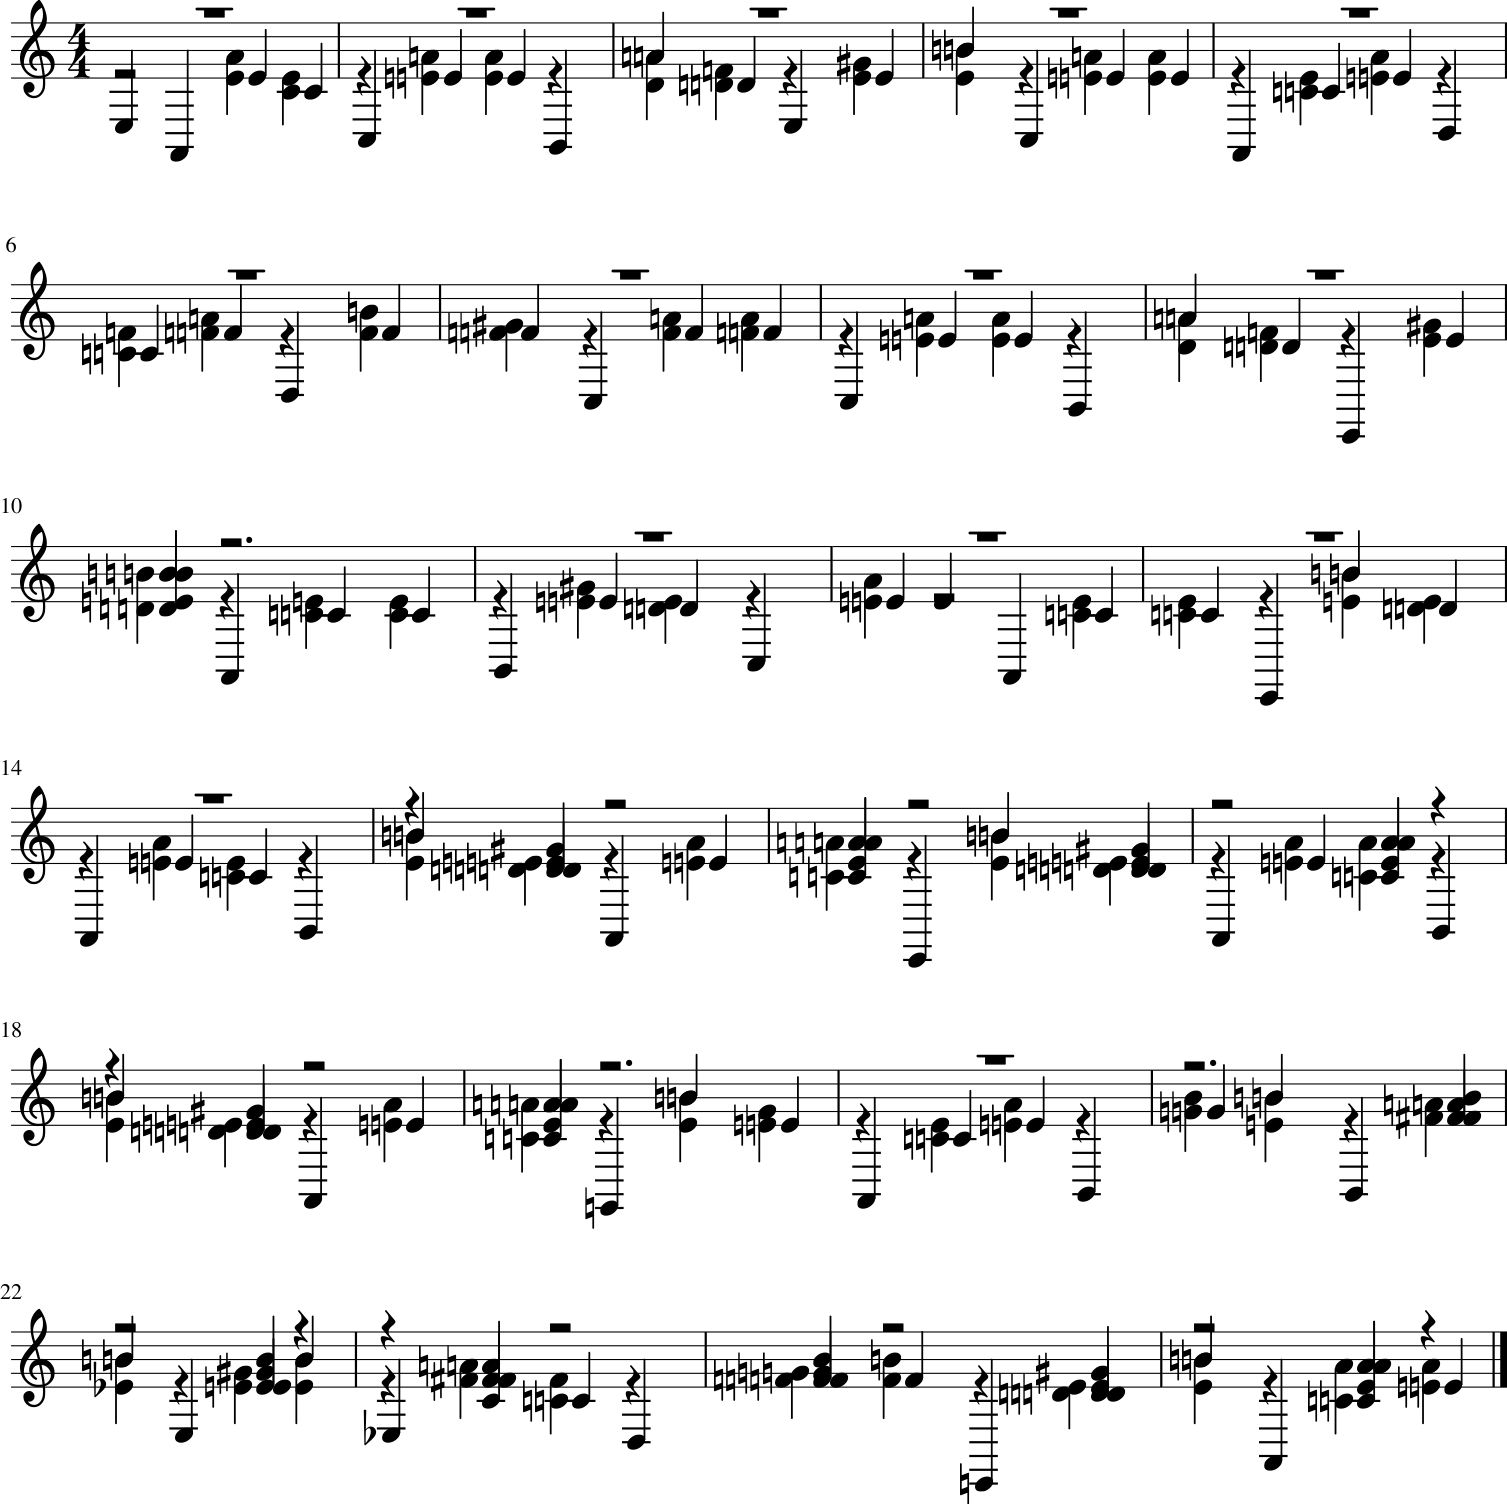

In [11]:
# Отобразим нотный стан
Melody_midi.show()

In [12]:
# Выведем в виде звуковой дорожки
Melody_midi.show('midi')

In [13]:
from collections import Counter
count_num = Counter(Corpus)
print("Общее число уникальных нот в корпусе:", len(count_num))

Общее число уникальных нот в корпусе: 397


In [14]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

# Средняя частота встречаемости нот в корпусе
def Average(rec):
    return sum(rec) / len(rec)

print('Средняя повторяемость ноты:', Average(Recurrence))
print('Наиболее часто встречаемые ноты:', max(Recurrence), 'раз')
print('Наиболее редкие ноты:', min(Recurrence), 'раз')

Средняя повторяемость ноты: 145.8287153652393
Наиболее часто встречаемые ноты: 1627 раз
Наиболее редкие ноты: 1 раз


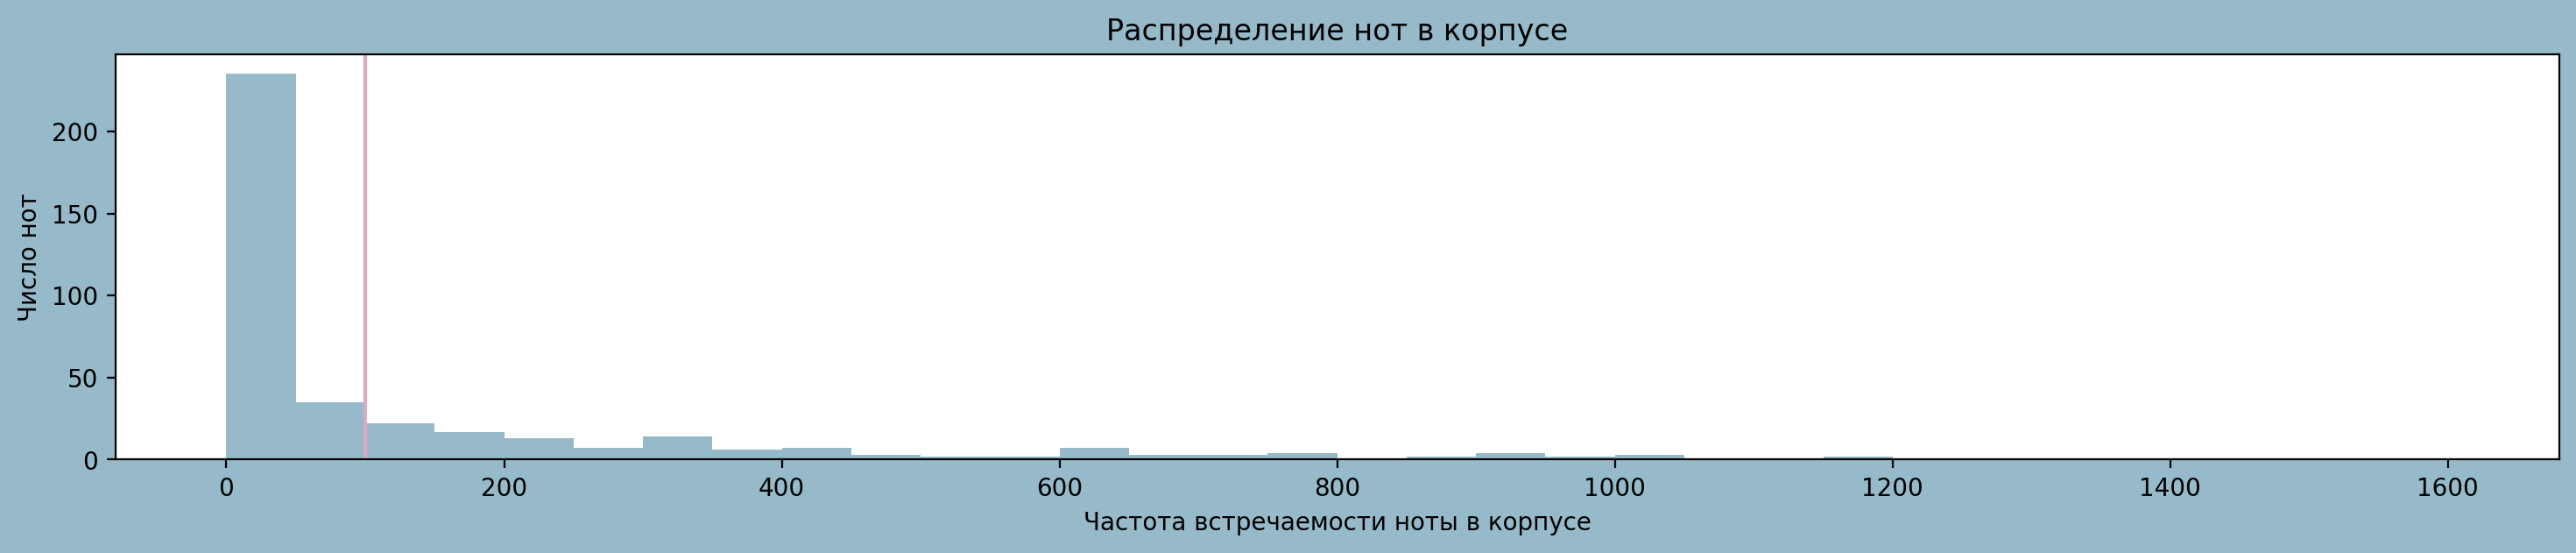

In [15]:
plt.figure(figsize=(18, 3), facecolor='#97BACB')
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color='#97BACB')
plt.axvline(x=100, color='#DBACC1') # отсечка по встречаемости в 100 раз
plt.title('Распределение нот в корпусе')
plt.xlabel('Частота встречаемости ноты в корпусе')
plt.ylabel('Число нот')
plt.show()

In [16]:
# Получение списка редких нот
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Общее число нот, которые повторяются менее 100 раз:", len(rare_note))

Общее число нот, которые повторяются менее 100 раз: 270


In [17]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Длина корпуса после исключения редких нот:", len(Corpus))

Длина корпуса после исключения редких нот: 53753


In [18]:
# Сохраняем все уникальные значения корпуса
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) # длина корпуса
L_symb = len(symb) # число уникальных элементов корпуса

# Создание словаря для доступа к словарному запасу из индексов и наоборот
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Общее число символов:", L_corpus)
print("Число уникальных символов:", L_symb)

Общее число символов: 53753
Число уникальных символов: 264


In [19]:
# длинны последовательностей
length = 40
# входные последовательности
features = []
# целевые последовательности
targets = []

# цикл разбиения корпуса
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Общее количество последовательностей в корпусе:", L_datapoints)

Общее количество последовательностей в корпусе: 53713


In [20]:
# изменение размера и нормализация входных данных
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one-hot encode для целевых выходных данных
y = tensorflow.keras.utils.to_categorical(targets)

print(f'Форма входных данных: {X.shape}')
print(f'Форма выходных данных: {y.shape}')

Форма входных данных: (53713, 40, 1)
Форма выходных данных: (53713, 264)


In [21]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:
model = Sequential()

model.add(LSTM(256, input_shape=X.shape[1:], return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 264)                 │          34,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 511,880 (1.95 MB)

 Trainable params: 511,880 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(X_train, y_train, batch_size=256, epochs=150)

Epoch 1/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - acc: 0.0228 - loss: 4.8701
Epoch 2/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - acc: 0.0293 - loss: 4.6737
Epoch 3/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0335 - loss: 4.4951
Epoch 4/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0377 - loss: 4.4472
Epoch 5/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.0380 - loss: 4.4291
Epoch 6/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0375 - loss: 4.4290
Epoch 7/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0410 - loss: 4.4138
Epoch 8/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.0401 - loss: 4.4056
Epoch 9/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0394 - loss: 4.3949
Epoch 10/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - acc: 0.0406 - loss: 4.3801
Epoch 11/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.0422 - loss: 4.3755
Epoch 12/150
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.0430 - loss: 4.3754
E

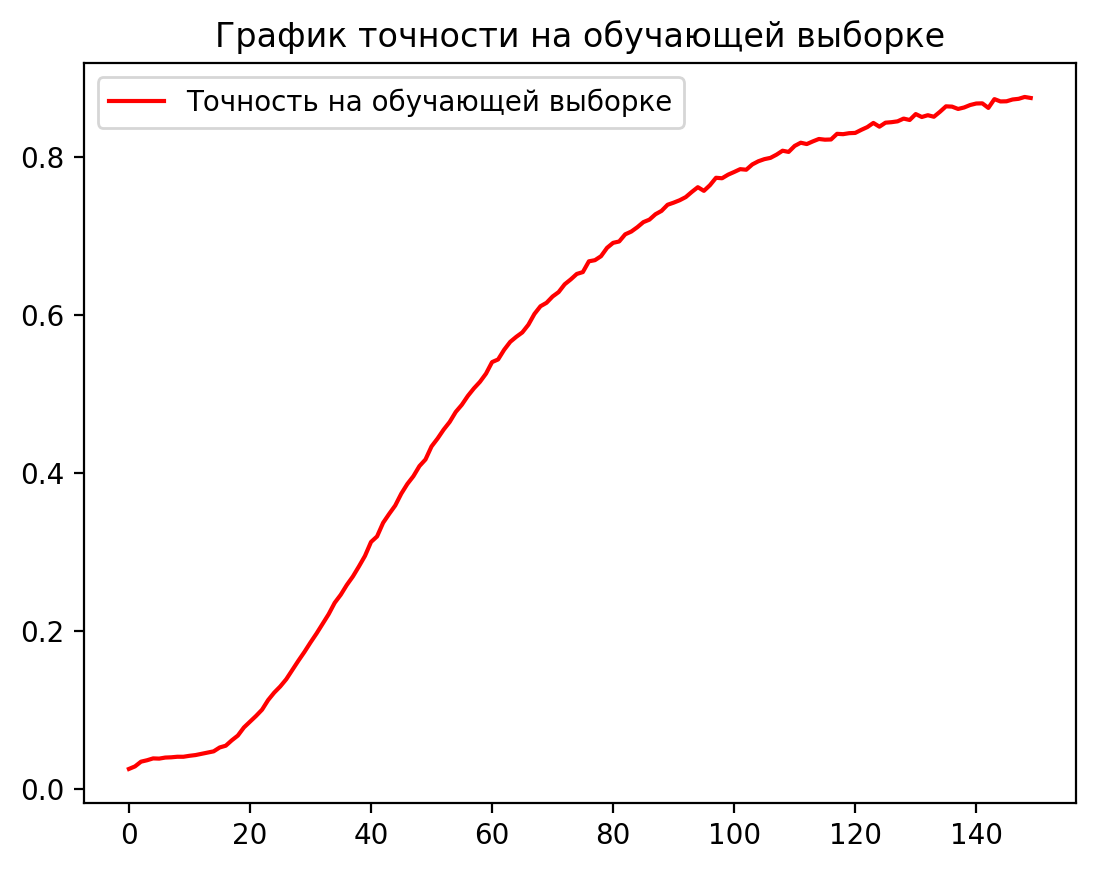

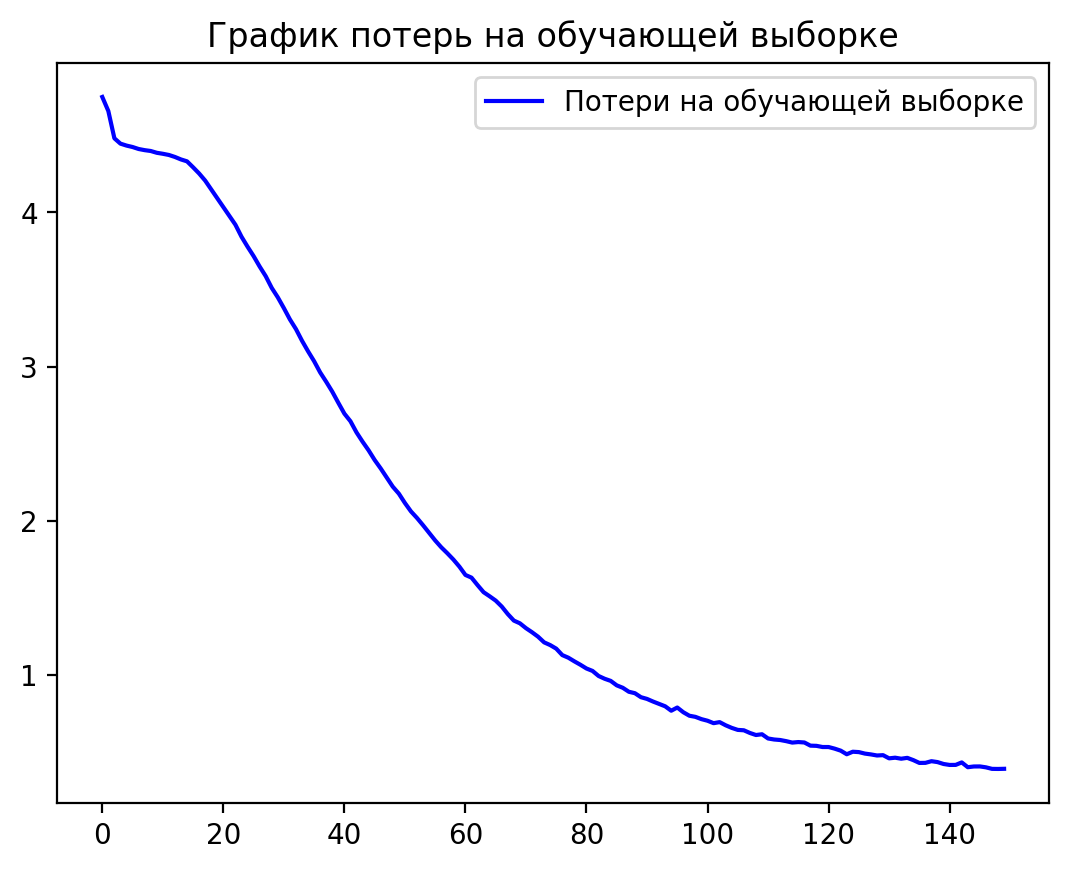

In [24]:
plt.plot(history.epoch, history.history['acc'], 'r', label='Точность на обучающей выборке')
plt.title('График точности на обучающей выборке')
plt.legend()
plt.figure()
plt.plot(history.epoch, history.history['loss'], 'b', label='Потери на обучающей выборке')
plt.title('График потерь на обучающей выборке')
plt.legend()
plt.show()

НИЖЕ КОД БЕЗ ИЗМЕНЕНИЯ ТЕМПЕРАТУРЫ

In [33]:
def music_generator(seq_len):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс наиболее вероятного класса
        index = np.argmax(prediction)

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)

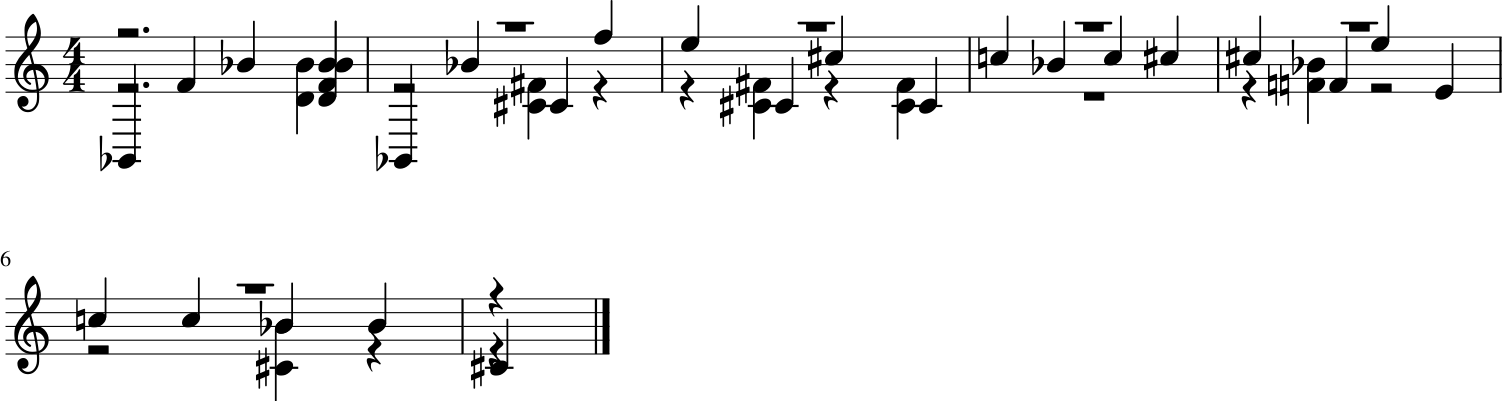

In [34]:
genMusic = music_generator(25)
genMidi = stream.Stream(genMusic)

# Отобразим нотный стан
genMidi.show()

In [35]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')

ЗДЕСЬ КОД С ИЗМЕНЕНИЕМ ТЕМПЕРАТУРЫ

In [102]:
def music_generator(seq_len, temperature):
    # случайный выбор начальной последовательности
    seed = X_seed[np.random.randint(0, len(X_seed)-1)]
    music = []
    notes = []
    for i in range(seq_len):
        # изменяем размер данных для передачи модели
        seed = seed.reshape(1, length, 1)

        # предсказываем по начальной последовательности
        prediction = model.predict(seed, verbose=0)[0]

        # предсказанные значения прогоняем через функцию softmax
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)

        # выбираем индекс c попоравкой на температуру
        const = round((len(prediction)- 1) * temperature)
        index = np.argmin(prediction) + const

        # нормализованный индекс в интервале [0, 1]
        # значение пойдет в seed, а там все значения в интервале [0, 1]
        index_N = index / float(L_symb)

        # складываем в список индекс предсказанной ноты
        notes.append(index)

        # обратное преобразование по словарю, на выходе последовательность нот
        music = [reverse_mapping[char] for char in notes]

        # seed всегда длины length
        # добавляем справа новое значение, а слева удаляем и уходим на новую итерацию цикла
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]

    return chords_n_notes(music)

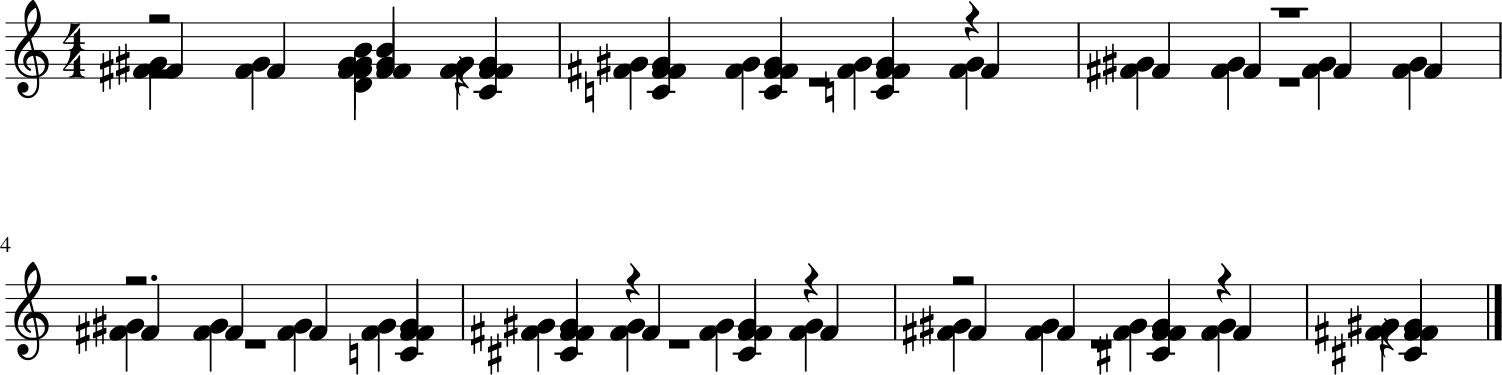

In [103]:
genMusic = music_generator(25, 0.5)
genMidi = stream.Stream(genMusic)

# Отобразим нотный стан
genMidi.show()

In [104]:
# Выведем в виде звуковой дорожки
genMidi.show('midi')